# Model Architectures

### Stacked LSTM

Stacked LSTM is basically stacking LSTM layer on top of each other which helps in in learning the pattern of data more better. The idea behind it that it allowes the model to perform hierarchical feature extraction, where lower layers capture basic features and higher layers capture more abstract features. This lead to better performance on tastks like time series data.

### Encoder-Stacked LSTM

This architecture consists of three parts, encoder, stacked LSTM and predictor. For the encoder I used CNNs to perform feature extraction and then feed the embeddings to stacked LSTMs to perform hierarchical feature extraction on these embeddings. The output vector then to be passed to a linear predictor (consists of MLP layers) to predict the output.

All in all, this model showed the best performance accross all datasets and its my go to model for this project.

### Vanilla LSTM

This is a one layer LSTM model. It has one layer of LSTM and a linear predictor which is the go to for any time series problem pretty much. It sometimes perform well but when the complexity of data increases it needs to be blended with other deep nerual network.

# Implementation

In [7]:
import warnings
import pickle
import math
import platform
import keras
import numpy as np
import tensorflow as tf
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from pandas import DataFrame
from numpy.random import RandomState
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.metrics import MeanSquaredError
from keras.models import Sequential, load_model
from keras.layers import Conv1D, BatchNormalization, Activation, Flatten, Dense, TimeDistributed, LSTM, RepeatVector
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from datetime import datetime, timedelta

In [ ]:
# filter and ignore warnings
warnings.filterwarnings('ignore')

# Define Constants and Methods

In [36]:
# Datasets file paths.
# FILE_PATH_TEMPLATE = "./%s_%s_%s_df.csv"
FILE_PATH_TEMPLATE = "/content/sample_data/%s_%s_%s_df.csv"

# Best model file path.
SL_FILE_PATH = "sl_best_model.h5"
ESL_FILE_PATH = "esl_best_model.h5"
VL_FILE_PATH = "vl_best_model.h5"

# Solar power plant constants
TOTAL_SOALR_PANEL_AREA = 10668
SOLAR_PANEL_YEILD = 0.2416
PERFORMANCE_RATIO = 0.75

# Wind power plant constants
COEFFICIENT_OF_PERFORMANCE = 0.3
AIR_DENSITY = 1.293
BLADE_LENGTH = 35
KILOMETER_PER_HOUR = 0.2778
NUMBER_OF_WIND_TURBINES = 20

EPOCHS = 10
BATCH = 128

# Number of houses in solar neighbourhood
SN_NUMBER_OF_HOUSES = 20
# Number of houses in wind neighbourhood
WN_NUMBER_OF_HOUSES = 200
# Safety factor to avoid false positives
SAFETY_FACTOR = 1.5
# Consumption per houshold per hour in MWh
HOURLY_CONSUMPTION_PER_HOUSE_MWH = 0.00031

# Consumption per neighbourhood per hour in MWh
SN_TOTAL_CONSUMPTION_PER_HOUR_MHW = SN_NUMBER_OF_HOUSES * SAFETY_FACTOR * \
  HOURLY_CONSUMPTION_PER_HOUSE_MWH
# Consumption per neighbourhood per hour in MWh
WN_TOTAL_CONSUMPTION_PER_HOUR_MHW = WN_NUMBER_OF_HOUSES * SAFETY_FACTOR * \
  HOURLY_CONSUMPTION_PER_HOUSE_MWH

# Datasets shapes right after loading.
SHAPES_DICT = {
    "colchester":{
        "solar_train": (104520, 15),
        "solar_val": (17520, 15),
        "solar_test": (8866, 15),
        "solar_predict": (24, 15),
        "wind_train": (184104, 15),
        "wind_val": (17520, 15),
        "wind_test": (8866, 15),
        "wind_predict": (24, 15),
    },
    "brighton": {
        "solar_train": (105192, 15),
        "solar_val": (17520, 15),
        "solar_test": (8892, 15),
        "solar_predict": (24, 15),
        "wind_train": (105192, 15),
        "wind_val": (17520, 15),
        "wind_test": (8892, 15),
        "wind_predict": (24, 15),
    }
}

In [33]:
def get_optimiser():
  """Switch to legacy adam on apple silicon devices

    Returns:
      Optimizer: Return adam or legacy adam optimiser
  """
  if platform.system() == "Darwin" and platform.processor() == "arm":
      return tf.keras.optimizers.legacy.Adam()
  else:
      return tf.keras.optimizers.Adam()

def get_callback_list(file_path):
  """Create callback that saves the best model during the training phase

    Returns:
      list: List of callbacks.
  """
  return [ModelCheckpoint(file_path, monitor='val_root_mean_squared_error',
                          verbose=1, save_best_only=True, mode='min')]


def to_supervised(train, n_in=24, window_size=24):
  """Convert time series dataset into supervised dataset, X_train, y"""
  X_train, y, in_start = [], [], 0

  for i in range(len(train)):
    in_end = in_start + n_in
    out_end = in_end + window_size

    if out_end <= len(train):
      X_train.append(train[in_start:in_end, :])
      y.append(train[in_end:out_end, 14])

    in_start += 1

  return np.array(X_train), np.array(y)

@keras.saving.register_keras_serializable(package="package", name="custom_fn")
def root_mean_squared_error(y_true, y_pred):
  """Implement RMSE to be used as metric in evaluating models"""
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

def scale_datasets(train, test, val, predict, area, energy_type) -> tuple:
  """Normalise datasets using MinMaxScaler"""
  scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

  scaler = scaler.fit(train)
  if energy_type == "solar":
    solar_radiation_train = train['solarradiation'].to_numpy()
    solar_radiation_train = solar_radiation_train.reshape(SHAPES_DICT[area][energy_type+"_train"][0], 1)
    y_scaler = y_scaler.fit(solar_radiation_train)
  else:
    wind_speed_train = train['windspeed'].to_numpy()
    wind_speed_train = wind_speed_train.reshape(SHAPES_DICT[area][energy_type+"_train"][0], 1)
    y_scaler = y_scaler.fit(wind_speed_train)


  train = scaler.transform(train)
  val = scaler.transform(val)
  test = scaler.transform(test)

  if energy_type == "solar":
    solar_radiation_predict = predict['solarradiation'].copy().to_numpy()
    predict = scaler.transform(predict)
    assert (predict[:, 14] == \
      (y_scaler.transform(solar_radiation_predict.reshape(24, 1))).reshape(1, -1)[0]).all()
  else:
    wind_speed_predict = predict['windspeed'].copy().to_numpy()
    predict = scaler.transform(predict)
    assert (predict[:, 14] == \
      (y_scaler.transform(wind_speed_predict.reshape(24, 1))).reshape(1, -1)[0]).all()


  return (train, test, val, predict, y_scaler)

def load_datasets(area, energy_type) -> tuple:
  """Load datasets."""
  train = pd.read_csv(FILE_PATH_TEMPLATE % ("train", area, energy_type), index_col=0)
  assert train.shape == SHAPES_DICT[area][energy_type+"_train"]

  val = pd.read_csv(FILE_PATH_TEMPLATE % ("val", area, energy_type), index_col=0)
  assert val.shape == SHAPES_DICT[area][energy_type+"_val"]

  test = pd.read_csv(FILE_PATH_TEMPLATE % ("test", area, energy_type), index_col=0)
  assert test.shape == SHAPES_DICT[area][energy_type+"_test"]

  predict = test.tail(24)
  assert predict.shape == SHAPES_DICT[area][energy_type+"_predict"]

  return (train, test, val, predict)

def plot_predictions_vs_actual(X_test, y_test, model, model_name) -> None:
  """plot predictions vs actual values on one graph"""
  y_predict = model.predict(X_test).flatten()
  y_test = y_test.flatten()

  df = pd.DataFrame(data={'Predictions': y_predict, 'Actuals':y_test})

  plt.figure(figsize =(5, 3.5))

  plt.plot(df['Predictions'], label="predictions")
  plt.plot(df['Actuals'], label="actual")

  plt.title('Prediction Vs Actual (%s)\n' % (model_name), fontsize = 14, fontweight ='bold')
  plt.legend(loc="upper left")

  plt.show()

def create_vanilla_lstm_model(X_train):
  """Build vanilla LSTM model"""
  model = Sequential()

  model.add(LSTM(50, activation='relu', return_sequences=True,
                input_shape=(X_train.shape[1], X_train.shape[2])))

  # Linear predictor.
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))

  print(model.summary())

  return model

def create_encoder_stacked_lstm_model(X_train):
  """Build encoder-stacked LSTM model"""
  model = Sequential()

  # CNN encoder for extracting features.
  model.add(Conv1D(64, kernel_size=4, strides=2, padding="same",
                  input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Activation("relu"))

  model.add(Conv1D(64, kernel_size=4, padding="same", strides=2))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Conv1D(64, kernel_size=4, padding="same", strides=2))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Conv1D(64, kernel_size=4, padding="same", strides=2))
  model.add(Activation("relu"))

  model.add(Flatten())

  model.add(RepeatVector(24))

  # Stacked LSTMs.
  model.add(LSTM(50, activation='relu', return_sequences=True,
                 input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(50, activation='relu', return_sequences=True))

  # Linear predictor.
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))

  print(model.summary())

  return model

def create_stacked_lstm_model(X_train):
  """Build stacked LSTM model"""
  model = Sequential()

  # Stacked LSTMs.
  model.add(LSTM(50, activation='relu', return_sequences=True,
                input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(50, activation='relu', return_sequences=True))
  model.add(LSTM(50, activation='relu', return_sequences=True))
  model.add(LSTM(50, activation='relu', return_sequences=True))

  # Linear predictor.
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))

  print(model.summary())

  return model

def compute_solar_energy_generation(annual_solar_radiation):
  """Compute annaual energy output of solar farm"""
  return math.floor(TOTAL_SOALR_PANEL_AREA * SOLAR_PANEL_YEILD * PERFORMANCE_RATIO \
                    * annual_solar_radiation * 1e-3)

def compute_wind_energy_generation(wind_energy):
  """Compute wind energy output for wind power plant per hour."""
  energy = []

  for wind_speed_ph in wind_energy['windspeed'].to_numpy().flatten():
    wind_speed_mps = KILOMETER_PER_HOUR * wind_speed_ph

    energy.append(1 * 0.5 * math.pi * COEFFICIENT_OF_PERFORMANCE * \
                 AIR_DENSITY * BLADE_LENGTH**2 * wind_speed_mps**3 * \
                  NUMBER_OF_WIND_TURBINES * 1e-6)

  wind_energy['gen_energy'] = DataFrame(np.array(energy)).set_index(wind_energy.index)

  return math.floor(sum(energy))

def sub_add_datetime(date, operation="sub", hours=None, days=None) -> str:
  """Method that allow sub and add to dates."""
  # Convert string to datetime object
  original_datetime = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

  # Subtract one year
  if operation == "sub":
    new_datetime = original_datetime - timedelta(days=days)
  else:
    new_datetime = original_datetime + timedelta(hours=hours)

  return new_datetime.strftime('%Y-%m-%d %H:%M:%S')

def create_prototype_df(test):
  """Create prototype dataframe to be used in showcase a real test case."""
  prototype = test.loc[sub_add_datetime(test.index[-1], days=365):test.index[-1]]

  all_indices = pd.date_range(prototype.index[0],
                              sub_add_datetime(prototype.index[-1], operation="add", hours=24),
                              freq="H").floor('H')

  prototype.index = pd.DatetimeIndex(prototype.index)

  prototype = prototype.reindex(all_indices, fill_value="TBF")

  return prototype

def fill_nans(series, predictions):
  """Merge prototype dataframe with predictions."""
  predictions = predictions
  result = []

  for value in series:
    if value == "TBF":
      value = predictions[0]
      predictions = np.delete(predictions, 0)
    result.append(value)

  return result

def compile_fit_evaluate_model(model, X_train, y_train, X_test, y_test, file_path):
  """Compile, fit and evaluate model."""
  model.compile(loss='mse', optimizer='adam',
                                     metrics=[MeanSquaredError(), root_mean_squared_error])

  model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH,
                                 validation_data=(X_val, y_val),
                                 callbacks=get_callback_list(file_path))

  model = load_model(file_path)

  return model.evaluate(x=X_test, y=y_test)


def check_for_slots(energy_df, neighbourhood):
  """Check for slots for customers to opt in after."""
  slots, surplus, limit_per_household= [], [], []

  gen_energy = energy_df.tail(24)['gen_energy'].to_numpy()
  total_consumption = energy_df.tail(24)['total_consumption'].to_numpy()

  for i in range(len(gen_energy)):
    slots.append(gen_energy[i] > total_consumption[i])
    surplus.append(gen_energy[i] - total_consumption[i])

    if neighbourhood == "sn":
      limit_per_household.append(surplus[i]/SN_NUMBER_OF_HOUSES)
    else:
      limit_per_household.append(surplus[i]/WN_NUMBER_OF_HOUSES)

  energy_df['slots'] = DataFrame(slots).set_index(energy_df.tail(24).index)
  energy_df['surplus'] = DataFrame(surplus).set_index(energy_df.tail(24).index)
  energy_df['limit_per_household'] = DataFrame(limit_per_household).set_index(energy_df.tail(24).index)

  return energy_df.tail(24).index[energy_df.tail(24)['slots'] == True].tolist()

# Predict Generated Solar Energy

## Load and Scale Colchester Solar Energy Datasets

In [5]:
# Load datasets.
train, test, val, predict = load_datasets("colchester", "solar")

# Crate prototype dataframe.
prototype_df = create_prototype_df(test)

# Normalise datasets using MinMax.
train, test, val, predict, y_scaler = scale_datasets(train, test, val, predict, "colchester", "solar")

# Convert datasets into X_train, y_train.
X_train, y_train = to_supervised(train)

# Convert datasets into X_val, y_val.
X_val, y_val = to_supervised(val)

# Convert datasets into X_test, y_test.
X_test, y_test = to_supervised(test)

# This dataset is to be used for prediction.
X_pred = predict

## Models to Predict Solar Energy in Colchester

### Stacked LSTMs

In [6]:
stacked_lstm_model = create_stacked_lstm_model(X_train)

compile_fit_evaluate_model(stacked_lstm_model, X_train, y_train, X_test, y_test, SL_FILE_PATH)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            13200     
                                                                 
 lstm_1 (LSTM)               (None, 24, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 24, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 24, 50)            20200     
                                                                 
 time_distributed (TimeDist  (None, 24, 100)           5100      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 24, 1)             101       
 stributed)                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


817/817 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048 - root_mean_squared_error: 0.0692
Epoch 2: val_root_mean_squared_error improved from 0.06813 to 0.06619, saving model to sl_best_model.h5
817/817 [==============================] - 120s 147ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_root_mean_squared_error: 0.0662
Epoch 3/10
817/817 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046 - root_mean_squared_error: 0.0676
Epoch 3: val_root_mean_squared_error did not improve from 0.06619
817/817 [==============================] - 118s 144ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_root_mean_squared_error: 0.0674
Epoch 4/10
817/817 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045 -

276/276 [==============================] - 6s 20ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - root_mean_squared_error: 0.0621


[0.0059900712221860886, 0.0059900712221860886, 0.06210671365261078]

276/276 [==============================] - 6s 21ms/step


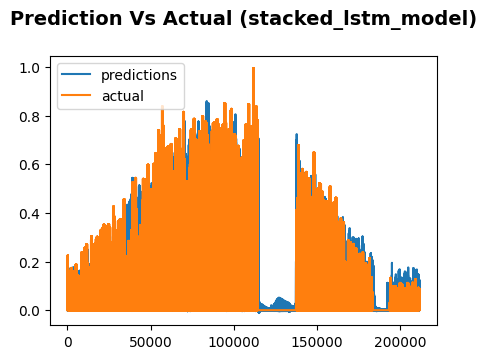

In [7]:
plot_predictions_vs_actual(X_test, y_test, stacked_lstm_model, "stacked_lstm_model")

### Encoder-Stacked LSTMs

In [8]:
encoder_stacked_lstm_model = create_encoder_stacked_lstm_model(X_train)

compile_fit_evaluate_model(encoder_stacked_lstm_model, X_train, y_train, X_test, y_test, ESL_FILE_PATH)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 64)            3904      
                                                                 
 activation (Activation)     (None, 12, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             16448     
                                                                 
 batch_normalization (Batch  (None, 6, 64)             256       
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 6, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             16448     
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


817/817 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045 - root_mean_squared_error: 0.0671
Epoch 2: val_root_mean_squared_error did not improve from 0.06553
817/817 [==============================] - 67s 82ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_root_mean_squared_error: 0.0679
Epoch 3/10
817/817 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042 - root_mean_squared_error: 0.0649
Epoch 3: val_root_mean_squared_error did not improve from 0.06553
817/817 [==============================] - 66s 81ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_root_mean_squared_error: 0.0668
Epoch 4/10
817/817 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040 - root_mean_squared_error: 0.0632
Epoch 4: 

276/276 [==============================] - 4s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - root_mean_squared_error: 0.0608


[0.005863017402589321, 0.005863017402589321, 0.060755446553230286]

276/276 [==============================] - 3s 10ms/step


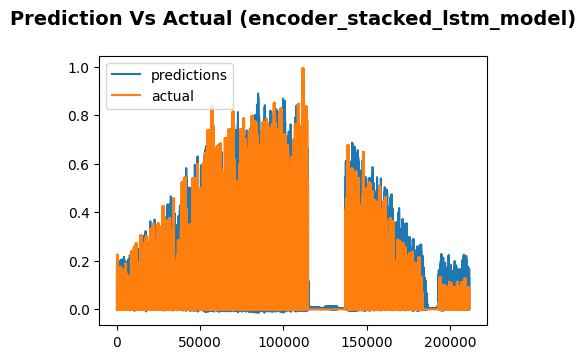

In [9]:
plot_predictions_vs_actual(X_test, y_test, encoder_stacked_lstm_model, "encoder_stacked_lstm_model")

### Vanilla LSTM

In [10]:
vanilla_lstm_model = create_vanilla_lstm_model(X_train)

compile_fit_evaluate_model(vanilla_lstm_model, X_train, y_train, X_test, y_test, VL_FILE_PATH)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 24, 50)            13200     
                                                                 
 time_distributed_4 (TimeDi  (None, 24, 100)           5100      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 24, 1)             101       
 stributed)                                                      
                                                                 
Total params: 18401 (71.88 KB)
Trainable params: 18401 (71.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
817/817 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066 - root_mean_squared_error: 0.0784
Epoch

276/276 [==============================] - 3s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - root_mean_squared_error: 0.0650


[0.006415916606783867, 0.006415916606783867, 0.06499649584293365]

276/276 [==============================] - 2s 6ms/step


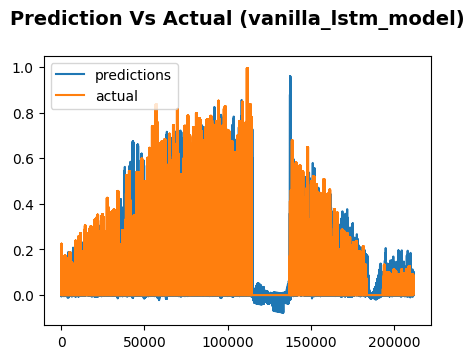

In [11]:
plot_predictions_vs_actual(X_test, y_test, vanilla_lstm_model, "vanilla_lstm_model")

### Computing Energy Generation of Power Plant

In [13]:
encoder_stacked_lstm_model = load_model(ESL_FILE_PATH)

pred = encoder_stacked_lstm_model.predict(X_pred.reshape(1, 24, 15))
pred

1/1 [==============================] - 1s 518ms/step


array([[[0.05248763],
        [0.07556027],
        [0.08015289],
        [0.06240587],
        [0.0398942 ],
        [0.02273908],
        [0.01402564],
        [0.01096133],
        [0.00929878],
        [0.00618149],
        [0.00359685],
        [0.00376827],
        [0.00102423],
        [0.00038342],
        [0.00572555],
        [0.01058778],
        [0.00975706],
        [0.00810164],
        [0.0076232 ],
        [0.00932123],
        [0.02143613],
        [0.03741986],
        [0.0534208 ],
        [0.0636943 ]]], dtype=float32)

In [14]:
pred = encoder_stacked_lstm_model.predict(X_pred.reshape(1, 24, 15))

pred_transformed = y_scaler.inverse_transform(pred[0])

pred_transformed.flatten()

1/1 [==============================] - 0s 24ms/step


array([55.321968  , 79.640526  , 84.48115   , 65.77579   , 42.04849   ,
       23.966995  , 14.783022  , 11.55324   ,  9.800909  ,  6.5152903 ,
        3.7910757 ,  3.9717605 ,  1.0795339 ,  0.40412164,  6.034734  ,
       11.15952   , 10.28394   ,  8.539124  ,  8.034853  ,  9.824573  ,
       22.593676  , 39.44053   , 56.305527  , 67.13379   ], dtype=float32)

In [15]:
solar_energy = DataFrame(prototype_df['solarradiation'])

solar_energy = solar_energy.apply(fill_nans, predictions=pred_transformed.flatten())

solar_energy['solarradiation'] = solar_energy['solarradiation'].apply(lambda x: 0 if x < 0 else x)

solar_energy.loc[solar_energy.index.hour < 5,'solarradiation'] = 0
solar_energy.loc[solar_energy.index.hour == 20,'solarradiation'] = 0
solar_energy.loc[solar_energy.index.hour == 21,'solarradiation'] = 0
solar_energy.loc[solar_energy.index.hour == 22,'solarradiation'] = 0
solar_energy.loc[solar_energy.index.hour == 23,'solarradiation'] = 0

In [16]:
annual_energy_generated = compute_solar_energy_generation(solar_energy['solarradiation'].mean())
print("Total energy generated by the solar plant in Colchester:", annual_energy_generated, "MWh")

Total energy generated by the solar plant in Colchester: 174 MWh


In [18]:
solar_energy['total_consumption'] = DataFrame(np.array([SN_TOTAL_CONSUMPTION_PER_HOUR_MHW] * solar_energy.shape[0])).set_index(solar_energy.index)
solar_energy['gen_energy'] = DataFrame(np.array([(annual_energy_generated/8670)] * solar_energy.shape[0])).set_index(solar_energy.index)

solar_energy

,solarradiation,total_consumption,gen_energy
2023-01-05 09:00:00,23.000000,0.0093,0.020069
2023-01-05 10:00:00,61.000000,0.0093,0.020069
2023-01-05 11:00:00,71.000000,0.0093,0.020069
2023-01-05 12:00:00,88.000000,0.0093,0.020069
2023-01-05 13:00:00,124.000000,0.0093,0.020069
...,...,...,...
2024-01-06 05:00:00,9.824573,0.0093,0.020069
2024-01-06 06:00:00,22.593676,0.0093,0.020069
2024-01-06 07:00:00,39.440529,0.0093,0.020069
2024-01-06 08:00:00,56.305527,0.0093,0.020069


### Decision Making

In [28]:
print("There are %s slot(s) available for customers to opt in" % (len(check_for_slots(solar_energy, "sn"))))
for i, slot in enumerate(check_for_slots(solar_energy, "sn")):
  print("There is a free slot on ", datetime.strptime(str(slot), '%Y-%m-%d %H:%M:%S'))

There are 24 slot(s) available for customers to opt in
There is a free slot on  2024-01-05 10:00:00
There is a free slot on  2024-01-05 11:00:00
There is a free slot on  2024-01-05 12:00:00
There is a free slot on  2024-01-05 13:00:00
There is a free slot on  2024-01-05 14:00:00
There is a free slot on  2024-01-05 15:00:00
There is a free slot on  2024-01-05 16:00:00
There is a free slot on  2024-01-05 17:00:00
There is a free slot on  2024-01-05 18:00:00
There is a free slot on  2024-01-05 19:00:00
There is a free slot on  2024-01-05 20:00:00
There is a free slot on  2024-01-05 21:00:00
There is a free slot on  2024-01-05 22:00:00
There is a free slot on  2024-01-05 23:00:00
There is a free slot on  2024-01-06 00:00:00
There is a free slot on  2024-01-06 01:00:00
There is a free slot on  2024-01-06 02:00:00
There is a free slot on  2024-01-06 03:00:00
There is a free slot on  2024-01-06 04:00:00
There is a free slot on  2024-01-06 05:00:00
There is a free slot on  2024-01-06 06:00:00


In [20]:
solar_energy.tail(24)

,solarradiation,total_consumption,gen_energy,slots,surplus,limit_per_household
2024-01-05 10:00:00,55.321968,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 11:00:00,79.640526,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 12:00:00,84.481148,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 13:00:00,65.775787,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 14:00:00,42.048489,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 15:00:00,23.966995,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 16:00:00,14.783022,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 17:00:00,11.553240,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 18:00:00,9.800909,0.0093,0.020069,True,0.010769,0.000538
2024-01-05 19:00:00,6.515290,0.0093,0.020069,True,0.010769,0.000538


## Load and Scale Brighton Solar Energy Datasets

In [11]:
# Load datasets.
train, test, val, predict = load_datasets("brighton", "solar")

# Crate prototype dataframe.
prototype_df = create_prototype_df(test)

# Normalise datasets using MinMax.
train, test, val, predict, y_scaler = scale_datasets(train, test, val, predict, "brighton", "solar")

# Convert datasets into X_train, y_train.
X_train, y_train = to_supervised(train)

# Convert datasets into X_val, y_val.
X_val, y_val = to_supervised(val)

# Convert datasets into X_test, y_test.
X_test, y_test = to_supervised(test)

# This dataset is to be used for prediction.
X_pred = predict

## Models to Predict Solar Energy in Brighton

### Stacked LSTMs

In [33]:
stacked_lstm_model = create_stacked_lstm_model(X_train)

compile_fit_evaluate_model(stacked_lstm_model, X_train, y_train, X_test, y_test, SL_FILE_PATH)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 24, 50)            13200     
                                                                 
 lstm_16 (LSTM)              (None, 24, 50)            20200     
                                                                 
 lstm_17 (LSTM)              (None, 24, 50)            20200     
                                                                 
 lstm_18 (LSTM)              (None, 24, 50)            20200     
                                                                 
 time_distributed_10 (TimeD  (None, 24, 100)           5100      
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 24, 1)             101       
 istributed)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


822/822 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067 - root_mean_squared_error: 0.0816
Epoch 2: val_root_mean_squared_error improved from 0.08624 to 0.08618, saving model to sl_best_model.h5
822/822 [==============================] - 118s 144ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_root_mean_squared_error: 0.0862
Epoch 3/10
822/822 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065 - root_mean_squared_error: 0.0803
Epoch 3: val_root_mean_squared_error did not improve from 0.08618
822/822 [==============================] - 120s 146ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_root_mean_squared_error: 0.0911
Epoch 4/10
822/822 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064 -

277/277 [==============================] - 7s 22ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - root_mean_squared_error: 0.0848


[0.00942920707166195, 0.00942920707166195, 0.08475329726934433]

277/277 [==============================] - 6s 18ms/step


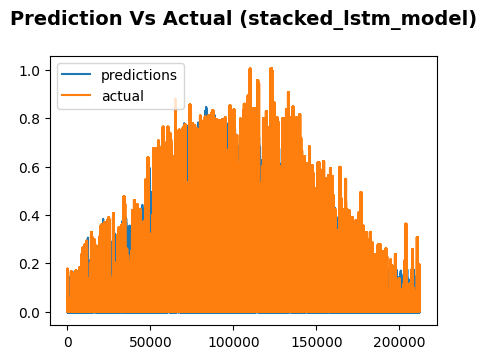

In [34]:
plot_predictions_vs_actual(X_test, y_test, stacked_lstm_model, "stacked_lstm_model")

### Encoder-Stacked LSTMs

In [12]:
encoder_stacked_lstm_model = create_encoder_stacked_lstm_model(X_train)

compile_fit_evaluate_model(encoder_stacked_lstm_model, X_train, y_train, X_test, y_test, ESL_FILE_PATH)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 64)            3904      
                                                                 
 activation (Activation)     (None, 12, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             16448     
                                                                 
 batch_normalization (Batch  (None, 6, 64)             256       
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 6, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             16448     
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


821/822 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061 - root_mean_squared_error: 0.0779
Epoch 2: val_root_mean_squared_error improved from 0.08860 to 0.08200, saving model to esl_best_model.h5
822/822 [==============================] - 70s 85ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_root_mean_squared_error: 0.0820
Epoch 3/10
822/822 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058 - root_mean_squared_error: 0.0759
Epoch 3: val_root_mean_squared_error did not improve from 0.08200
822/822 [==============================] - 68s 83ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_root_mean_squared_error: 0.0901
Epoch 4/10
822/822 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056 - ro

[0.008650468662381172, 0.008650468662381172, 0.08086815476417542]

277/277 [==============================] - 3s 9ms/step


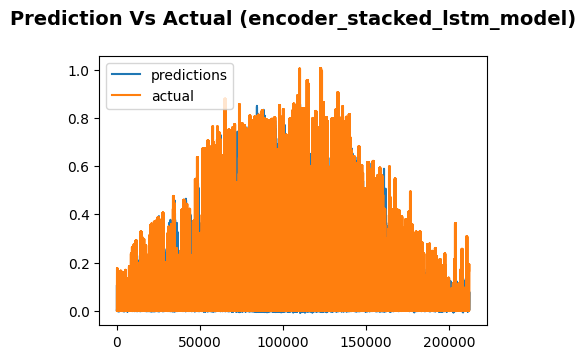

In [13]:
plot_predictions_vs_actual(X_test, y_test, encoder_stacked_lstm_model, "encoder_stacked_lstm_model")

### Vanilla LSTM

In [39]:
vanilla_lstm_model = create_vanilla_lstm_model(X_train)

compile_fit_evaluate_model(vanilla_lstm_model, X_train, y_train, X_test, y_test, VL_FILE_PATH)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 24, 50)            13200     
                                                                 
 time_distributed_12 (TimeD  (None, 24, 100)           5100      
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 24, 1)             101       
 istributed)                                                     
                                                                 
Total params: 18401 (71.88 KB)
Trainable params: 18401 (71.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
821/822 [============================>.] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081 - root_mean_squared_error: 0.0876
Epoch

277/277 [==============================] - 2s 7ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - root_mean_squared_error: 0.0855


[0.009434809908270836, 0.009434809908270836, 0.0855417475104332]

277/277 [==============================] - 2s 6ms/step


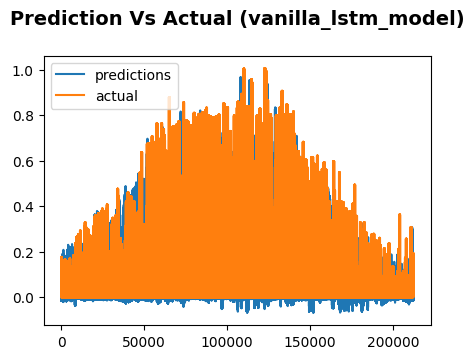

In [40]:
plot_predictions_vs_actual(X_test, y_test, vanilla_lstm_model, "vanilla_lstm_model")

### Computing Energy Generation of Power Plant

In [14]:
pred = encoder_stacked_lstm_model.predict(X_pred.reshape(1, 24, 15))
pred

1/1 [==============================] - 0s 232ms/step


array([[[0.1565306 ],
        [0.13018693],
        [0.07820623],
        [0.02876716],
        [0.00575813],
        [0.00144808],
        [0.0013014 ],
        [0.00209014],
        [0.00199002],
        [0.00240447],
        [0.00200859],
        [0.00112017],
        [0.00092422],
        [0.00189372],
        [0.00167768],
        [0.00199277],
        [0.0020339 ],
        [0.00173272],
        [0.00216052],
        [0.00872557],
        [0.02804969],
        [0.06686508],
        [0.10456792],
        [0.1141802 ]]], dtype=float32)

In [15]:
pred = encoder_stacked_lstm_model.predict(X_pred.reshape(1, 24, 15))

pred_transformed = y_scaler.inverse_transform(pred[0])

pred_transformed.flatten()

1/1 [==============================] - 0s 120ms/step


array([166.86162  , 138.77927  ,  83.367836 ,  30.665792 ,   6.1381674,
         1.5436572,   1.3872908,   2.2280846,   2.1213655,   2.563165 ,
         2.1411538,   1.1941038,   0.9852228,   2.018701 ,   1.7884057,
         2.1242924,   2.16814  ,   1.8470836,   2.3031156,   9.301455 ,
        29.90097  ,  71.278175 , 111.469406 , 121.716095 ], dtype=float32)

In [16]:
solar_energy = DataFrame(prototype_df['solarradiation'])

# Merge prediction to solar_energy df
solar_energy = solar_energy.apply(fill_nans, predictions=pred_transformed.flatten())

# Assume any negative prediction is 0.
solar_energy['solarradiation'] = solar_energy['solarradiation'].apply(lambda x: 0 if x < 0 else x)

# Make sure that solarradiation is 0 at these times.
solar_energy.loc[solar_energy.index.hour < 5,'solarradiation'] = 0
solar_energy.loc[solar_energy.index.hour == 20,'solarradiation'] = 0
solar_energy.loc[solar_energy.index.hour == 21,'solarradiation'] = 0
solar_energy.loc[solar_energy.index.hour == 22,'solarradiation'] = 0
solar_energy.loc[solar_energy.index.hour == 23,'solarradiation'] = 0

In [17]:
annual_energy_generated = compute_solar_energy_generation(solar_energy['solarradiation'].mean())
print("Total energy generated by the solar plant in Brighton:", annual_energy_generated, "MWh")

Total energy generated by the solar plant in Brighton: 231 MWh


In [18]:
solar_energy['total_consumption'] = DataFrame(np.array([SN_TOTAL_CONSUMPTION_PER_HOUR_MHW] * solar_energy.shape[0])).set_index(solar_energy.index)
solar_energy['gen_energy'] = DataFrame(np.array([(annual_energy_generated/8670)] * solar_energy.shape[0])).set_index(solar_energy.index)

solar_energy

,solarradiation,total_consumption,gen_energy
2023-01-06 11:00:00,177.000000,0.0093,0.026644
2023-01-06 12:00:00,135.000000,0.0093,0.026644
2023-01-06 13:00:00,71.000000,0.0093,0.026644
2023-01-06 14:00:00,37.000000,0.0093,0.026644
2023-01-06 15:00:00,19.000000,0.0093,0.026644
...,...,...,...
2024-01-07 07:00:00,9.301455,0.0093,0.026644
2024-01-07 08:00:00,29.900970,0.0093,0.026644
2024-01-07 09:00:00,71.278175,0.0093,0.026644
2024-01-07 10:00:00,111.469406,0.0093,0.026644


### Decision Making

In [19]:
print("There are %s slot(s) available for customers to opt in" % (len(check_for_slots(solar_energy, "sn"))))
for i, slot in enumerate(check_for_slots(solar_energy, "sn")):
  print("There is a free slot on ", datetime.strptime(str(slot), '%Y-%m-%d %H:%M:%S'))

There are 24 slot(s) available for customers to opt in
There is a free slot on  2024-01-06 12:00:00
There is a free slot on  2024-01-06 13:00:00
There is a free slot on  2024-01-06 14:00:00
There is a free slot on  2024-01-06 15:00:00
There is a free slot on  2024-01-06 16:00:00
There is a free slot on  2024-01-06 17:00:00
There is a free slot on  2024-01-06 18:00:00
There is a free slot on  2024-01-06 19:00:00
There is a free slot on  2024-01-06 20:00:00
There is a free slot on  2024-01-06 21:00:00
There is a free slot on  2024-01-06 22:00:00
There is a free slot on  2024-01-06 23:00:00
There is a free slot on  2024-01-07 00:00:00
There is a free slot on  2024-01-07 01:00:00
There is a free slot on  2024-01-07 02:00:00
There is a free slot on  2024-01-07 03:00:00
There is a free slot on  2024-01-07 04:00:00
There is a free slot on  2024-01-07 05:00:00
There is a free slot on  2024-01-07 06:00:00
There is a free slot on  2024-01-07 07:00:00
There is a free slot on  2024-01-07 08:00:00


In [20]:
solar_energy.tail(24)

,solarradiation,total_consumption,gen_energy,slots,surplus,limit_per_household
2024-01-06 12:00:00,166.861618,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 13:00:00,138.779266,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 14:00:00,83.367836,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 15:00:00,30.665792,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 16:00:00,6.138167,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 17:00:00,1.543657,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 18:00:00,1.387291,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 19:00:00,2.228085,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 20:00:00,0.000000,0.0093,0.026644,True,0.017344,0.000867
2024-01-06 21:00:00,0.000000,0.0093,0.026644,True,0.017344,0.000867


# Predict Generated Wind Energy

## Load and Scale Colchester Wind Energy Datasets

In [21]:
train, test, val, predict = load_datasets("colchester", "wind")

prototype_df = create_prototype_df(test)

train, test, val, predict, y_scaler = scale_datasets(train, test, val, predict, "colchester", "wind")

X_train, y_train = to_supervised(train)

X_val, y_val = to_supervised(val)

X_test, y_test = to_supervised(test)

X_pred = predict

## Models to Predict Wind Energy in Colchester

### Stacked LSTMs

In [48]:
stacked_lstm_model = create_stacked_lstm_model(X_train)

compile_fit_evaluate_model(stacked_lstm_model, X_train, y_train, X_test, y_test, SL_FILE_PATH)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 24, 50)            13200     
                                                                 
 lstm_21 (LSTM)              (None, 24, 50)            20200     
                                                                 
 lstm_22 (LSTM)              (None, 24, 50)            20200     
                                                                 
 lstm_23 (LSTM)              (None, 24, 50)            20200     
                                                                 
 time_distributed_14 (TimeD  (None, 24, 100)           5100      
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 24, 1)             101       
 istributed)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1438/1438 [==============================] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086 - root_mean_squared_error: 0.0923
Epoch 2: val_root_mean_squared_error improved from 0.09154 to 0.08794, saving model to sl_best_model.h5
1438/1438 [==============================] - 201s 140ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - root_mean_squared_error: 0.0923 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_root_mean_squared_error: 0.0879
Epoch 3/10
1438/1438 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082 - root_mean_squared_error: 0.0903
Epoch 3: val_root_mean_squared_error did not improve from 0.08794
1438/1438 [==============================] - 213s 148ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_root_mean_squared_error: 0.0888
Epoch 4/10
1438/1438 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error

276/276 [==============================] - 7s 22ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - root_mean_squared_error: 0.1062


[0.021411269903182983, 0.021411269903182983, 0.10622705519199371]

276/276 [==============================] - 7s 22ms/step


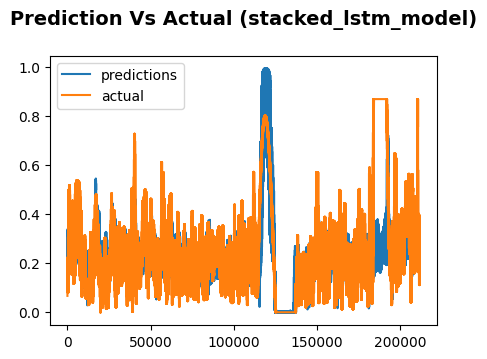

In [49]:
plot_predictions_vs_actual(X_test, y_test, stacked_lstm_model, "stacked_lstm_model")

### Encoder-Stacked LSTMs

In [22]:
encoder_stacked_lstm_model = create_encoder_stacked_lstm_model(X_train)

compile_fit_evaluate_model(encoder_stacked_lstm_model, X_train, y_train, X_test, y_test, ESL_FILE_PATH)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 12, 64)            3904      
                                                                 
 activation_4 (Activation)   (None, 12, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 64)             16448     
                                                                 
 batch_normalization_2 (Bat  (None, 6, 64)             256       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 6, 64)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 3, 64)             16448     
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1438/1438 [==============================] - 143s 97ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - root_mean_squared_error: 0.0861 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_root_mean_squared_error: 0.0696
Epoch 2/10
1438/1438 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060 - root_mean_squared_error: 0.0773
Epoch 2: val_root_mean_squared_error did not improve from 0.06956
1438/1438 [==============================] - 145s 101ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_root_mean_squared_error: 0.0744
Epoch 3/10
1438/1438 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057 - root_mean_squared_error: 0.0755
Epoch 3: val_root_mean_squared_error improved from 0.06956 to 0.06845, saving model to esl_best_model.h5
1438/1438 [==============================] - 147s 102ms/step - loss: 0.0057 - mean_squar

[0.007308566477149725, 0.007308566477149725, 0.07528896629810333]

276/276 [==============================] - 5s 18ms/step


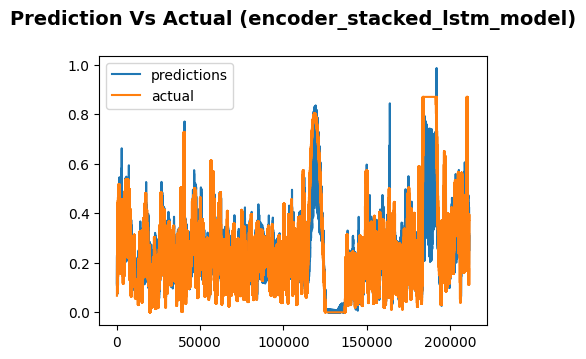

In [23]:
plot_predictions_vs_actual(X_test, y_test, encoder_stacked_lstm_model, "encoder_stacked_lstm_model")

### Vanilla LSTM

In [24]:
vanilla_lstm_model = create_vanilla_lstm_model(X_train)

compile_fit_evaluate_model(vanilla_lstm_model, X_train, y_train, X_test, y_test, VL_FILE_PATH)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 50)            13200     
                                                                 
 time_distributed_4 (TimeDi  (None, 24, 100)           5100      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 24, 1)             101       
 stributed)                                                      
                                                                 
Total params: 18401 (71.88 KB)
Trainable params: 18401 (71.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
1437/1438 [============================>.] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105 - root_mean_squared_error: 0.1004
Epo

[0.011292356997728348, 0.011292356997728348, 0.09247217327356339]

276/276 [==============================] - 2s 6ms/step


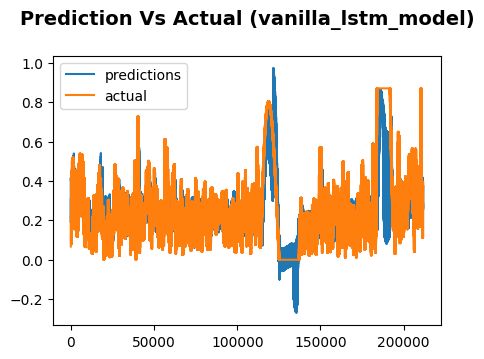

In [25]:
plot_predictions_vs_actual(X_test, y_test, vanilla_lstm_model, "vanilla_lstm_model")

### Computing Energy Generation of Power Plant

In [26]:
pred = encoder_stacked_lstm_model.predict(X_pred.reshape(1, 24, 15))
pred

1/1 [==============================] - 0s 47ms/step


array([[[0.33807224],
        [0.3439906 ],
        [0.3406589 ],
        [0.3352561 ],
        [0.32562977],
        [0.31148362],
        [0.2942661 ],
        [0.27920973],
        [0.26801273],
        [0.25965577],
        [0.25373667],
        [0.2504808 ],
        [0.2480929 ],
        [0.24569963],
        [0.24209313],
        [0.23891124],
        [0.23643589],
        [0.23521583],
        [0.23643775],
        [0.24147059],
        [0.24726114],
        [0.25425482],
        [0.26049614],
        [0.26509598]]], dtype=float32)

In [27]:
pred = encoder_stacked_lstm_model.predict(X_pred.reshape(1, 24, 15))

pred_transformed = y_scaler.inverse_transform(pred[0])

pred_transformed.flatten()

1/1 [==============================] - 0s 86ms/step


array([25.253996, 25.696098, 25.44722 , 25.04363 , 24.324543, 23.267826,
       21.981678, 20.856968, 20.020552, 19.396286, 18.95413 , 18.710917,
       18.53254 , 18.353762, 18.084356, 17.84667 , 17.66176 , 17.570621,
       17.6619  , 18.037853, 18.470407, 18.992834, 19.45906 , 19.80267 ],
      dtype=float32)

In [28]:
wind_energy = DataFrame(prototype_df['windspeed'])

wind_energy = wind_energy.apply(fill_nans, predictions=pred_transformed.flatten())

wind_energy

,windspeed
2023-01-05 09:00:00,15.800000
2023-01-05 10:00:00,16.300000
2023-01-05 11:00:00,19.300000
2023-01-05 12:00:00,20.800000
2023-01-05 13:00:00,25.200000
...,...
2024-01-06 05:00:00,18.037853
2024-01-06 06:00:00,18.470407
2024-01-06 07:00:00,18.992834
2024-01-06 08:00:00,19.459061


In [37]:
annual_energy_generated = compute_wind_energy_generation(wind_energy)
print("Total energy generated by the wind power plant in Colchester:", annual_energy_generated, "MWh")

Total energy generated by the wind power plant in Colchester: 64113 MWh


In [38]:
wind_energy['total_consumption'] = DataFrame(np.array([WN_TOTAL_CONSUMPTION_PER_HOUR_MHW] * wind_energy.shape[0])).set_index(wind_energy.index)

### Decision Making

In [41]:
print("There are %s slot(s) available for customers to opt in" % (len(check_for_slots(wind_energy, "wn"))))
for i, slot in enumerate(check_for_slots(wind_energy, "wn")):
  print("There is a free slot on ", datetime.strptime(str(slot), '%Y-%m-%d %H:%M:%S'))

There are 24 slot(s) available for customers to opt in
There is a free slot on  2024-01-05 10:00:00
There is a free slot on  2024-01-05 11:00:00
There is a free slot on  2024-01-05 12:00:00
There is a free slot on  2024-01-05 13:00:00
There is a free slot on  2024-01-05 14:00:00
There is a free slot on  2024-01-05 15:00:00
There is a free slot on  2024-01-05 16:00:00
There is a free slot on  2024-01-05 17:00:00
There is a free slot on  2024-01-05 18:00:00
There is a free slot on  2024-01-05 19:00:00
There is a free slot on  2024-01-05 20:00:00
There is a free slot on  2024-01-05 21:00:00
There is a free slot on  2024-01-05 22:00:00
There is a free slot on  2024-01-05 23:00:00
There is a free slot on  2024-01-06 00:00:00
There is a free slot on  2024-01-06 01:00:00
There is a free slot on  2024-01-06 02:00:00
There is a free slot on  2024-01-06 03:00:00
There is a free slot on  2024-01-06 04:00:00
There is a free slot on  2024-01-06 05:00:00
There is a free slot on  2024-01-06 06:00:00


In [42]:
wind_energy.tail(24)

,windspeed,gen_energy,total_consumption,slots,surplus,limit_per_household
2024-01-05 10:00:00,25.253996,5.154574,0.093,True,5.061574,0.025308
2024-01-05 11:00:00,25.696098,5.430052,0.093,True,5.337052,0.026685
2024-01-05 12:00:00,25.447220,5.273798,0.093,True,5.180798,0.025904
2024-01-05 13:00:00,25.043631,5.026832,0.093,True,4.933832,0.024669
2024-01-05 14:00:00,24.324543,4.606134,0.093,True,4.513134,0.022566
2024-01-05 15:00:00,23.267826,4.031530,0.093,True,3.938530,0.019693
2024-01-05 16:00:00,21.981678,3.399265,0.093,True,3.306265,0.016531
2024-01-05 17:00:00,20.856968,2.903728,0.093,True,2.810728,0.014054
2024-01-05 18:00:00,20.020552,2.568210,0.093,True,2.475210,0.012376
2024-01-05 19:00:00,19.396286,2.335383,0.093,True,2.242383,0.011212


## Load and Scale Brighton Wind Energy Datasets

In [43]:
# Load datasets.
train, test, val, predict = load_datasets("brighton", "wind")

# Crate prototype dataframe.
prototype_df = create_prototype_df(test)

# Normalise datasets using MinMax.
train, test, val, predict, y_scaler = scale_datasets(train, test, val, predict, "brighton", "wind")

# Convert datasets into X_train, y_train.
X_train, y_train = to_supervised(train)

# Convert datasets into X_val, y_val.
X_val, y_val = to_supervised(val)

# Convert datasets into X_test, y_test.
X_test, y_test = to_supervised(test)

# This dataset is to be used for prediction.
X_pred = predict

## Models to Predict Wind Energy in Brighton

### Stacked LSTMs

In [ ]:
stacked_lstm_model = create_stacked_lstm_model(X_train)

compile_fit_evaluate_model(stacked_lstm_model, X_train, y_train, X_test, y_test, SL_FILE_PATH)

In [ ]:
plot_predictions_vs_actual(X_test, y_test, stacked_lstm_model, "stacked_lstm_model")

### Encoder-Stacked LSTMs

In [44]:
encoder_stacked_lstm_model = create_encoder_stacked_lstm_model(X_train)

compile_fit_evaluate_model(encoder_stacked_lstm_model, X_train, y_train, X_test, y_test, ESL_FILE_PATH)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 12, 64)            3904      
                                                                 
 activation_8 (Activation)   (None, 12, 64)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 6, 64)             16448     
                                                                 
 batch_normalization_4 (Bat  (None, 6, 64)             256       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 6, 64)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 3, 64)             16448     
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


822/822 [==============================] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105 - root_mean_squared_error: 0.1025
Epoch 2: val_root_mean_squared_error did not improve from 0.10160
822/822 [==============================] - 71s 87ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_root_mean_squared_error: 0.1025
Epoch 3/10
822/822 [==============================] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101 - root_mean_squared_error: 0.1002
Epoch 3: val_root_mean_squared_error did not improve from 0.10160
822/822 [==============================] - 77s 94ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - root_mean_squared_error: 0.1002 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_root_mean_squared_error: 0.1024
Epoch 4/10
822/822 [==============================] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096 - root_mean_squared_error: 0.0980
Epoch 4: 

[0.011539861559867859, 0.011539861559867859, 0.09989706426858902]

277/277 [==============================] - 3s 9ms/step


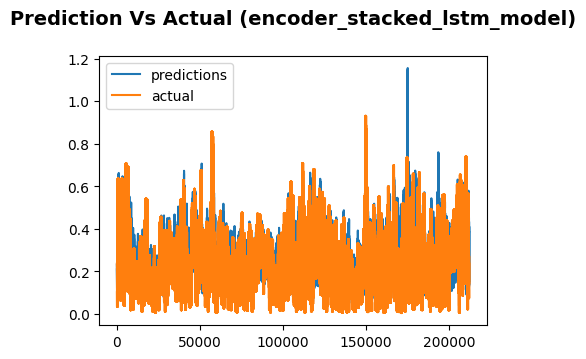

In [45]:
plot_predictions_vs_actual(X_test, y_test, encoder_stacked_lstm_model, "encoder_stacked_lstm_model")

### Vanilla LSTM

In [ ]:
vanilla_lstm_model = create_vanilla_lstm_model(X_train)

compile_fit_evaluate_model(vanilla_lstm_model, X_train, y_train, X_test, y_test, VL_FILE_PATH)

In [ ]:
plot_predictions_vs_actual(X_test, y_test, vanilla_lstm_model, "vanilla_lstm_model")

### Computing Energy Generation of Power Plant

In [46]:
pred = encoder_stacked_lstm_model.predict(X_pred.reshape(1, 24, 15))
pred

1/1 [==============================] - 0s 37ms/step


array([[[0.23627579],
        [0.23468482],
        [0.22549711],
        [0.21044892],
        [0.19263263],
        [0.17646803],
        [0.16401972],
        [0.15619968],
        [0.15172502],
        [0.14888364],
        [0.1476762 ],
        [0.1485261 ],
        [0.15219991],
        [0.1579412 ],
        [0.1654233 ],
        [0.17444101],
        [0.18496908],
        [0.19730078],
        [0.20964037],
        [0.22187106],
        [0.233386  ],
        [0.24210447],
        [0.25024596],
        [0.2579375 ]]], dtype=float32)

In [47]:
pred = encoder_stacked_lstm_model.predict(X_pred.reshape(1, 24, 15))

pred_transformed = y_scaler.inverse_transform(pred[0])

pred_transformed.flatten()

1/1 [==============================] - 0s 36ms/step


array([15.972243 , 15.864695 , 15.243605 , 14.226347 , 13.021966 ,
       11.929239 , 11.087733 , 10.559098 , 10.256612 , 10.064534 ,
        9.982911 , 10.040364 , 10.288713 , 10.676826 , 11.182615 ,
       11.7922125, 12.50391  , 13.337532 , 14.171689 , 14.998484 ,
       15.776894 , 16.366262 , 16.916626 , 17.436575 ], dtype=float32)

In [49]:
wind_energy = DataFrame(prototype_df['windspeed'])

wind_energy = wind_energy.apply(fill_nans, predictions=pred_transformed.flatten())

wind_energy

,windspeed
2023-01-06 11:00:00,14.100000
2023-01-06 12:00:00,13.200000
2023-01-06 13:00:00,16.600000
2023-01-06 14:00:00,20.200000
2023-01-06 15:00:00,21.800000
...,...
2024-01-07 07:00:00,14.998484
2024-01-07 08:00:00,15.776894
2024-01-07 09:00:00,16.366262
2024-01-07 10:00:00,16.916626


In [50]:
annual_energy_generated = compute_wind_energy_generation(wind_energy)
print("Total energy generated by the wind power plant in Brighton:", annual_energy_generated, "MWh")

Total energy generated by the wind power plant in Brighton: 24741 MWh


In [51]:
wind_energy['total_consumption'] = DataFrame(np.array([WN_TOTAL_CONSUMPTION_PER_HOUR_MHW] * wind_energy.shape[0])).set_index(wind_energy.index)

### Decision Making

In [52]:
print("There are %s slot(s) available for customers to opt in" % (len(check_for_slots(wind_energy, "wn"))))
for i, slot in enumerate(check_for_slots(wind_energy, "wn")):
  print("There is a free slot on ", datetime.strptime(str(slot), '%Y-%m-%d %H:%M:%S'))

There are 24 slot(s) available for customers to opt in
There is a free slot on  2024-01-06 12:00:00
There is a free slot on  2024-01-06 13:00:00
There is a free slot on  2024-01-06 14:00:00
There is a free slot on  2024-01-06 15:00:00
There is a free slot on  2024-01-06 16:00:00
There is a free slot on  2024-01-06 17:00:00
There is a free slot on  2024-01-06 18:00:00
There is a free slot on  2024-01-06 19:00:00
There is a free slot on  2024-01-06 20:00:00
There is a free slot on  2024-01-06 21:00:00
There is a free slot on  2024-01-06 22:00:00
There is a free slot on  2024-01-06 23:00:00
There is a free slot on  2024-01-07 00:00:00
There is a free slot on  2024-01-07 01:00:00
There is a free slot on  2024-01-07 02:00:00
There is a free slot on  2024-01-07 03:00:00
There is a free slot on  2024-01-07 04:00:00
There is a free slot on  2024-01-07 05:00:00
There is a free slot on  2024-01-07 06:00:00
There is a free slot on  2024-01-07 07:00:00
There is a free slot on  2024-01-07 08:00:00


In [53]:
wind_energy.tail(24)

,windspeed,gen_energy,total_consumption,slots,surplus,limit_per_household
2024-01-06 12:00:00,15.972243,1.304068,0.093,True,1.211068,0.006055
2024-01-06 13:00:00,15.864695,1.277902,0.093,True,1.184902,0.005925
2024-01-06 14:00:00,15.243605,1.133615,0.093,True,1.040615,0.005203
2024-01-06 15:00:00,14.226347,0.921473,0.093,True,0.828473,0.004142
2024-01-06 16:00:00,13.021966,0.706695,0.093,True,0.613695,0.003068
2024-01-06 17:00:00,11.929239,0.543301,0.093,True,0.450301,0.002252
2024-01-06 18:00:00,11.087733,0.436245,0.093,True,0.343245,0.001716
2024-01-06 19:00:00,10.559098,0.376776,0.093,True,0.283776,0.001419
2024-01-06 20:00:00,10.256612,0.345314,0.093,True,0.252314,0.001262
2024-01-06 21:00:00,10.064534,0.326275,0.093,True,0.233275,0.001166
